# Emergency-911 Probability Estimation and Methods Reports

In this dataset, our **first objective** is to explore the dataset. See if there is and direct correlation between the emergency call location and the emergency type. This file contains the algorithm along with analysis on the results.

In [1]:
# Importing main libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
# Import data

df = pd.read_csv('../input/911.csv', low_memory=False, nrows=1000)
df = df[['lat', 'lng', 'title']]

df.head(10)

,lat,lng,title
0,40.297876,-75.581294,EMS: BACK PAINS/INJURY
1,40.258061,-75.264680,EMS: DIABETIC EMERGENCY
2,40.121182,-75.351975,Fire: GAS-ODOR/LEAK
3,40.116153,-75.343513,EMS: CARDIAC EMERGENCY
4,40.251492,-75.603350,EMS: DIZZINESS
5,40.253473,-75.283245,EMS: HEAD INJURY
6,40.182111,-75.127795,EMS: NAUSEA/VOMITING
7,40.217286,-75.405182,EMS: RESPIRATORY EMERGENCY
8,40.289027,-75.399590,EMS: SYNCOPAL EPISODE
9,40.102398,-75.291458,Traffic: VEHICLE ACCIDENT -


Since parameters for our prediction are **longitude and latitude** ve can ignore rest of the data for now. Let's plot a graph to see how our data is spread.

**Instead of using all of the elements in "title" column and spreading our data thin, we downgraded our data to 3 main type:**
- **Fire**
- **EMS**
- **Traffic**

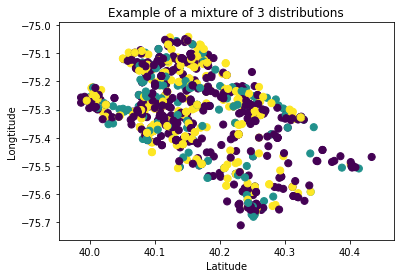

In [3]:
from sklearn.datasets.samples_generator import make_blobs


for i in range (0, df.shape[0]):
    df.iloc[i, 2] = df.iloc[i, 2][: df.iloc[i, 2].find(":")]
    
temp = np.unique(df['title'])
types = dict()
for type_id in range(0, len(temp)):
    types[temp[type_id]] = type_id

del temp

y = df.iloc[:, 2]
y = y.replace(types)

n_components = len(types)
X, truth = make_blobs(n_samples=df.shape[0], centers=n_components)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], s=50, c = y)
plt.title(f"Example of a mixture of {n_components} distributions")
plt.xlabel("Latitude")
plt.ylabel("Longtitude");

From the graph above, **we cannot see any direct seperation of emergency type according to logtitude and latitude.** It makes finding the form of the density of this distribution not plausable. Instead of trying to find a form, we can try to find a probability depending on the calls around the input location.

With the approach we will be using **Nonparametric Methods**, we are assuming that calls from similar neighbourhood have similar emergency types. 

Types of Nonparametric Methods we can use are:
- Histogram Estimator
- Naive Estimator
- Kernel Estimator
- K Nearest Neighbor Estimator

### Case against Histogram Estimator:
In histogram estimator, we are dealing with fixed sized location boxes, we will refer these boxes as blocks. In the case of histogram estimator, we will select our neighbourhoods as prefixed sized blocks. Which means, model's prediction on new coordinates will only be effected by the points in that block. This approach may lead the model to not to use the closest points of the new call because they are not in the same block.

### Case against Naive and Kernel Estimators:
In these estimation methods, we are dealing with a fixed radius around the new point. In **Naive**, effects of the neighbouring points are weighted binary (1 or 0); if it is in the circle it is 1, if not it is 0. In **Kernel**, effects of the neighbouring points are weighted much smoothly than Naive Estimators. The problem is, if there is no or little amount of neighbours in this points radius, we have very little or nothing to work on and we lost a lot of processing time.

### Case against K Nearest Neighbor Estimator:
In K Nearest Neighbor Estimator, we are dealing with a prefixed amount of neighbouring points. Which means, model's prediction on new coordinates will only be effected by these points. If the new point is an outlier or the neighbours are scattered far away from each others, there can be kilometers of distance between the point and the neighbours. 

## Estimator Selection
Out of these estimators, Naive Estimator is a good method to use. Neighbours we are using in this method are more likely to be related to our point rather than KNN and Histogram Estimator. Also, less costly than Kernel Estimator.
**Down Below we implement olur Naive Estimator:**

In [4]:
def naive_estimator_evidence(neighbourhood, point, dataset):
    '''
        @arg neighbourhood: float
        @arg point: Array
        @arg dataset: pandas.DataFrame
        
        returns float
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.

    '''
    application_matrix = (point[0] - neighbourhood / 2) < dataset['lat']
    application_matrix *= (point[0] + neighbourhood / 2) >= dataset['lat']
    application_matrix *= (point[1] - neighbourhood / 2) < dataset['lng']
    application_matrix *= (point[1] + neighbourhood / 2) >= dataset['lng']
    
    return ((sum(application_matrix) / dataset.shape[0]))

In [5]:
def naive_estimator_likelihood(neighbourhood, point, dataset, emergency):
    '''
        @arg neighbourhood: float
        @arg point: array
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        
        @returns float
                neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
    '''
    emergency_set = dataset[dataset['title'] == emergency]
    likelihood = naive_estimator_evidence(neighbourhood, point, emergency_set)
    
    return (likelihood)

In [6]:
def prior(dataset, emergency):
    '''
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        
        @returns float
        
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
    '''
    emergency_set = dataset[dataset['title'] == emergency]
    prior = emergency_set.shape[0] / dataset.shape[0]
    
    return (prior)

In [7]:
def normalized_posterior(prior, likelihood, evidence):
    '''
        @arg prior: float
        @arg likelihood: float
        @arg evidence: float, evidence != 0
        
        @returns float
        
        prior:
            Prior probability value of the posterior to be calculated.
        likelihood:
            Likelihood value of the posterior to be calculated.
        evidence:
            Evidence value of the posterior to be calculated.
    '''
    
    posterior = prior * likelihood / evidence
    return(posterior)

In [8]:
def naive_estimator_posterior(neighbourhood, point, dataset, emergency):
    '''
        @arg neighbourhood: float
        @arg point: Array
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        
        @return float
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
    '''
    
    __evidence = naive_estimator_evidence(neighbourhood, point, df)
    __likelihood = naive_estimator_likelihood(neighbourhood, point, df, emergency)
    __prior = prior(df, emergency)
    __posterior = normalized_posterior(__prior, __likelihood, __evidence)
    
    return __posterior

Final **naive_estimator_posterior** calculates the probability of emergency="EMS: BACK PAINS/INJURY" given point [40.2, -75.2] and neighbourhood koordinate radius of 1 unit. Other probabilities of this kind can be found like this.

## Improving Naive Estimator
If we leave or function like above, and given neighbourhood is too small, there can be situations which posterior is 0, just because we cannot reach to and other neighbor. We can add an expantion rate to our algorith so of probability is 0 we expand. If an event has never occured, expanding while probability is 0 can be dangerous, so we can limit our search with minimum and maximum boundaries of available data. Also we can show how wide of a search we are doing for better judment.

In [9]:
def naive_estimator_posterior_expandable(neighbourhood, point, dataset, emergency, expantion_rate=0.001):
    '''
        @arg neighbourhood: float
        @arg point: Array
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        @arg expantion_rate: float, default=0.001
        
        returns Array[float, float]
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
        expantion_rate:
            In case of not finding any available data points inside the given area, function expands its area
            by the expantion_rate.
    '''
    
    lat_boundaries = [dataset['lat'].min(), dataset['lat'].max()]
    lng_boundaries = [dataset['lng'].min(), dataset['lng'].max()]
    
    __evidence = naive_estimator_evidence(neighbourhood, point, df)
    
    while (__evidence == 0):
        if (lat_boundaries[0] > (point[0] - neighbourhood) and lat_boundaries[1] <= (point[0] + neighbourhood) and lng_boundaries[0] > (point[1] - neighbourhood) and lng_boundaries[1] <= (point[1] + neighbourhood)):
            return [neighbourhood, 0]
        
        neighbourhood += expantion_rate
        __evidence = naive_estimator_evidence(neighbourhood, point, df)
    
    __likelihood = naive_estimator_likelihood(neighbourhood, point, df, emergency)
    __prior = prior(df, emergency)
    __posterior = normalized_posterior(__prior, __likelihood, __evidence)
    
    while (__posterior == 0):
        if (lat_boundaries[0] > (point[0] - neighbourhood) and lat_boundaries[1] <= (point[0] + neighbourhood) and lng_boundaries[0] > (point[1] - neighbourhood) and lng_boundaries[1] <= (point[1] + neighbourhood)):
            return [neighbourhood, 0]
        
        neighbourhood += expantion_rate
        __evidence = naive_estimator_evidence(neighbourhood, point, df)
        __likelihood = naive_estimator_likelihood(neighbourhood, point, df, emergency)
        __posterior = normalized_posterior(__prior, __likelihood, __evidence)

    
    return [__posterior, neighbourhood]

Now our function can search for at least one point until it reaches the edges of all corners.

## Kernel Estimator
If we want to take it one step further, we can use a non-binary weight function so further a neighbour get from the point, less effective it is. We can use Gaussian kernel for the weight function.

In [10]:
import math

def gaussian_kernel(x):
    result = (1/math.sqrt(2 * math.pi)) * math.exp(-(x**2)/2)
    return (result)

Since this kernel only works with one random variable, we can find the euclidian distance between points and then call it with dividing it to radius to get a normalized value inside the circle, between 0 and 1.

We will rewrite our evidance, likelihood and posterior function to work with gaussian weights.

In [11]:
def euclidian_dist(x, y):
    '''
        @arg x: pandas.Series
        @arg y: pandas.Series
        
        @returns float
    '''
    result = math.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
    return (result)

In [12]:
def kernel_estimator_evidence(neighbourhood, point, dataset):
    '''
        @arg neighbourhood: float
        @arg point: pandas.Series
        @arg dataset: pandas.DataFrame
        
        @return float
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
    '''
    application_matrix = (point[0] - neighbourhood / 2) < dataset['lat']
    application_matrix *= (point[0] + neighbourhood / 2) >= dataset['lat']
    application_matrix *= (point[1] - neighbourhood / 2) < dataset['lng']
    application_matrix *= (point[1] + neighbourhood / 2) >= dataset['lng']
    
    neighbors = dataset[application_matrix]
    evidence = 0
    
    for i in range (0, neighbors.shape[0]):
        item = neighbors.iloc[i, :2]
        distance = euclidian_dist(point, item)
        gaussian_weight = gaussian_kernel(distance)
        evidence += gaussian_weight
    return evidence / dataset.shape[0]

In [13]:
def kernel_estimator_likelihood(neighbourhood, point, dataset, emergency):
    '''
        @arg neighbourhood: float
        @arg point: pandas.Series
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        
        @return float
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
    '''
    emergency_set = dataset[dataset['title'] == emergency]
    likelihood = kernel_estimator_evidence(neighbourhood, point, emergency_set)
    
    return (likelihood)

In [14]:
def kernel_estimator_posterior_expandable(neighbourhood, point, dataset, emergency, expantion_rate=0.001):
    '''
        @arg neighbourhood: float
        @arg point: pandas.Series
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        @arg expantion_rate: float
        
        @return float
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
        expantion_rate:
            In case of not finding any available data points inside the given area, function expands its area
            by the expantion_rate.
    '''
        
    lat_boundaries = [dataset['lat'].min(), dataset['lat'].max()]
    lng_boundaries = [dataset['lng'].min(), dataset['lng'].max()]
    
    __evidence = kernel_estimator_evidence(neighbourhood, point, df)
    
    while (__evidence == 0):
        if (lat_boundaries[0] > (point[0] - neighbourhood) and lat_boundaries[1] <= (point[0] + neighbourhood) and lng_boundaries[0] > (point[1] - neighbourhood) and lng_boundaries[1] <= (point[1] + neighbourhood)):
            return [neighbourhood, 0]
        
        neighbourhood += expantion_rate
        __evidence = kernel_estimator_evidence(neighbourhood, point, df)
    
    __likelihood = kernel_estimator_likelihood(neighbourhood, point, df, emergency)
    __prior = prior(df, emergency)
    __posterior = normalized_posterior(__prior, __likelihood, __evidence)
    
    while (__posterior == 0):
        if (lat_boundaries[0] > (point[0] - neighbourhood) and lat_boundaries[1] <= (point[0] + neighbourhood) and lng_boundaries[0] > (point[1] - neighbourhood) and lng_boundaries[1] <= (point[1] + neighbourhood)):
            return [neighbourhood, 0]
        
        neighbourhood += expantion_rate
        __evidence = kernel_estimator_evidence(neighbourhood, point, df)
        __likelihood = kernel_estimator_likelihood(neighbourhood, point, df, emergency)
        __posterior = normalized_posterior(__prior, __likelihood, __evidence)

    
    return [__posterior, neighbourhood]

In [15]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :2]
y = df.iloc[:, 2]
train, test = train_test_split(df, test_size=0.2, random_state=21)

X_test = test.iloc[:, :2]
y_test = test.iloc[:, 2]

In [16]:
# Calculate accuracy for Naive Estimator

result = []
temp = np.unique(df['title'])

for i in range(0, X_test.shape[0]):
    best_posterior = 0
    best_class = ''
    for title in temp:
        posterior = naive_estimator_posterior(0.001, X_test.iloc[i, :], train, title)
        
        if(posterior > best_posterior):
            best_posterior = posterior
            best_class = title
    result.append(best_class)
    
print("Accuracy for naive_estimator_posterior with 0.001 neighbour: ", sum(result == y_test) / len(result) * 100)
                                              

/opt/conda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Accuracy for naive_estimator_posterior with 0.001 neighbour:  87.5


In [17]:
# Calculate accuracy for Extended Naive Estimator

result = []
temp = np.unique(df['title'])

for i in range(0, X_test.shape[0]):
    best_posterior = 0
    best_class = ''
    for title in temp:
        posterior = naive_estimator_posterior_expandable(0.001, X_test.iloc[i, :], train, title, expantion_rate=0.001)
        
        if(posterior[0] > best_posterior):
            best_posterior = posterior[0]
            best_class = title
    result.append(best_class)
    
print("Accuracy for naive_estimator_posterior with 0.001 neighbour: ", sum(result == y_test) / len(result) * 100)
                                              

Accuracy for naive_estimator_posterior with 0.001 neighbour:  87.5


In [18]:
# Calculate accuracy for Gaussian Kernel Estimator

result = []
temp = np.unique(df['title'])

for i in range(0, X_test.shape[0]):
    best_posterior = 0
    best_class = ''
    for title in temp:
        posterior = kernel_estimator_posterior_expandable(0.001, X_test.iloc[i, :], train, title, expantion_rate=0.001)
        
        if(posterior[0] > best_posterior):
            best_posterior = posterior[0]
            best_class = title

    result.append(best_class)
    
print("Accuracy for naive_estimator_posterior with 0.001 neighbour: ", sum(result == y_test) / len(result) * 100)
                                              

Accuracy for naive_estimator_posterior with 0.001 neighbour:  88.0


**Since the algorithims above are not optimized for performance, only a percentage of the data set is used with 1/10000th precision on coordinates.**

- **Naive Estimator** and **Extended Naive Estimator** gives similar accuracies. But Extended Naive Estimator can sometimes have a lower accuracy; because when it expands its radius, it has a chance to reach to a neighbour with no relation to the point of interest.

- Even though **Gaussian Kernel Estimator** shares the expantion of its radius propery with the Extended Naive Estimator, it gives better results because it weights data with Gaussian Kernel which means closer to the point of interest, more relevant to the result and farther from the point of interest, less relevant to the result. This can correct some major issues in Estended Naive Estimator and fixes the problem of not finding and neighbours in a given radius with Naive Estimator.

